# CSC 546 Project on the HEp-2 Cells dataset.  Ryan Smith

# Basic information on the matlab file, labels.mat using SciPy.

In [1]:
import scipy.io as sio

# Load the .mat file
mat_file = sio.loadmat('labels.mat')

# Access the variables
labels = mat_file['labels']

# Print the shape of the array
print(labels.shape) 

# Print the total number of data points
print(labels.size)

(1, 63445)
63445


# Full Code From Start to Finish

Phase 1: Loading labels
Number of labels: 63445
Phase 1 completed in 0.00 seconds
Phase 2: Loading image paths
Number of image paths: 63445
Phase 2 completed in 0.01 seconds
Phase 3: Randomly selecting 1% of data
Sample size: 634
Sample indices size: 634
Sample paths size: 634
Sample labels size: 634
Phase 3 completed in 0.00 seconds
Phase 4: Preprocessing images
Unique label values before saving: [0 1 2 3 4 5]
Saved preprocessed images, labels, and SIFT features to disk.
Valid images size: 300
Valid labels size: 300
Unique label values after loading from disk: [0 1 2 3 4 5]


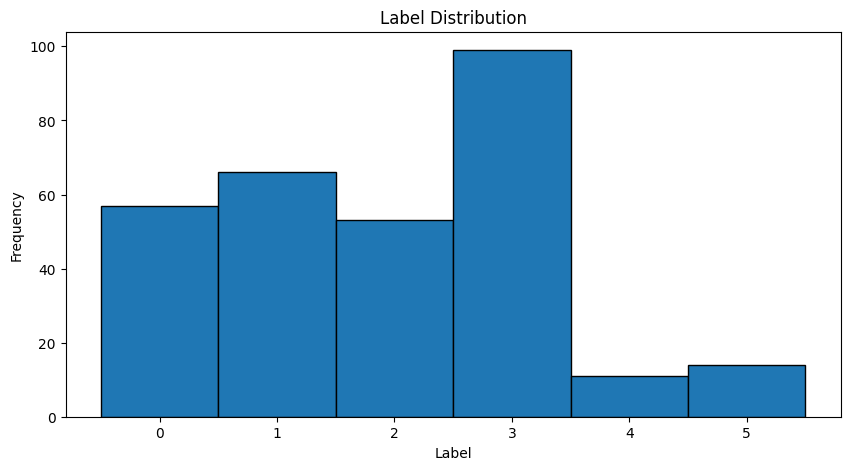

Phase 4 completed in 1444.58 seconds
Phase 5: Splitting data into training and validation sets
Phase 5 completed in 0.01 seconds
Unique training labels: [0 1 2 3 4 5]
Unique validation labels: [0 1 2 3 4 5]
Phase 6: Building CNN model
Phase 6 completed in 0.03 seconds
Phase 7: Training CNN model
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.2738 - loss: 1.7199 - val_accuracy: 0.3333 - val_loss: 1.5770
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3357 - loss: 1.4982 - val_accuracy: 0.4500 - val_loss: 1.4130
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4685 - loss: 1.2553 - val_accuracy: 0.4667 - val_loss: 1.2685
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5205 - loss: 1.0929 - val_accuracy: 0.4833 - val_loss: 1.2056
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5665 - loss: 1.0050 - val_accuracy: 0.5333 - val_loss: 1.1152
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6045 - loss: 0.

In [30]:
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time
import matplotlib.pyplot as plt

# Description:
# This script performs supervised learning for classifying biological cell images. It starts by loading labels from a MATLAB file and image paths from a text file. It then randomly selects 1% of the data for processing if preprocessed data is not already saved. The images are preprocessed by resizing to 128x128 pixels, scaling, and adding a channel dimension. The data is split into training and validation sets. A Convolutional Neural Network (CNN) is built and trained on the training set, and its performance is evaluated on the validation set. The script includes error handling for missing images and prints messages indicating the current phase of processing, along with timers to measure the time taken for each phase. Intermediate results are saved to disk to speed up future runs.

# Check if preprocessed images and labels are already saved
# This section checks if the preprocessed images and labels are already saved on disk. If the files 'preprocessed_images.npy' and 'valid_labels.npy' exist, it loads the preprocessed images and labels from these files. This avoids redundant preprocessing and ensures consistency in the data used for training and validation. If the files do not exist, the script proceeds to load and preprocess the data.
if os.path.exists('preprocessed_images.npy') and os.path.exists('valid_labels.npy') and os.path.exists('sift_features.npy'):
    print("Loading preprocessed images, labels, and SIFT features from disk.")
    images = np.load('preprocessed_images.npy')
    valid_labels = np.load('valid_labels.npy')
    sift_features = np.load('sift_features.npy', allow_pickle=True)
    print(f"Loaded preprocessed images, labels, and SIFT features from disk.")
else:
    # 1. Load labels
    # This phase involves loading the labels from a MATLAB file. The labels are stored in a .mat file, which is loaded using the scipy.io.loadmat function. The labels are then flattened to ensure they are in a 1D array format. This step is crucial as it provides the ground truth for the classification task.
    print("Phase 1: Loading labels")
    start_time = time.time()
    labels = loadmat('labels.mat')['labels'].flatten()  # Ensure labels are flattened
    print(f"Number of labels: {len(labels)}")
    print(f"Phase 1 completed in {time.time() - start_time:.2f} seconds")

    # Adjust labels to be 0-indexed (i.e., from 0 to 5)
    # This step adjusts the labels to be 0-indexed by subtracting 1 from each label value. This ensures that the labels are in the range [0, 5], which is required for the classification task. The adjustment is necessary because the original labels might be 1-indexed.
    labels = labels - 1

    # 2. Load images
    # In this phase, the script reads the paths of the images from a text file. Each line in the text file corresponds to the path of an image. These paths are stored in a list for further processing. This step is essential to locate the images that will be used for training and validation.
    print("Phase 2: Loading image paths")
    start_time = time.time()
    with open('cells2.txt', 'r') as f:
        image_paths = [line.strip() for line in f.readlines()]
    print(f"Number of image paths: {len(image_paths)}")
    print(f"Phase 2 completed in {time.time() - start_time:.2f} seconds")

    # Ensure the number of labels matches the number of image paths
    # This assertion ensures that the number of labels matches the number of image paths. It is a crucial validation step to ensure data integrity, as each image must have a corresponding label for the classification task.
    assert len(labels) == len(image_paths), "Number of labels does not match number of image paths"

    # 3. Randomly select 1% of data
    # This phase involves randomly selecting 1% of the total dataset for processing. The random.sample function is used to select a subset of indices, which are then used to extract the corresponding image paths and labels. This step helps in reducing the computational load by working with a smaller, representative subset of the data.
    print("Phase 3: Randomly selecting 1% of data")
    start_time = time.time()
    sample_size = int(0.01 * len(image_paths))
    sample_indices = random.sample(range(len(image_paths)), sample_size)
    sample_paths = [image_paths[i] for i in sample_indices]
    sample_labels = labels[sample_indices]
    print(f"Sample size: {sample_size}")
    print(f"Sample indices size: {len(sample_indices)}")
    print(f"Sample paths size: {len(sample_paths)}")
    print(f"Sample labels size: {len(sample_labels)}")
    print(f"Phase 3 completed in {time.time() - start_time:.2f} seconds")

    # 4. Preprocess images
    # In this phase, the images are preprocessed to prepare them for input into the CNN. Each image is read in grayscale mode, resized to 128x128 pixels, scaled to a range of [0, 1], and reshaped to add a channel dimension. If an image cannot be loaded, a warning is printed, and the image is skipped. This step ensures that the images are in the correct format for the CNN.
    print("Phase 4: Preprocessing images")
    start_time = time.time()
    sift = cv2.SIFT_create()  # Create SIFT object

    def preprocess_image_and_extract_sift(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Image at path {path} could not be loaded.")
            return None, None
        img_resized = cv2.resize(img, (128, 128))  # Resize to 128x128 pixels
        keypoints, descriptors = sift.detectAndCompute(img_resized, None)  # Extract SIFT features
        img_resized = img_resized / 255.0  # Scaling
        img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
        return img_resized, descriptors

    images = []
    valid_labels = []
    sift_features = []
    for path, label in zip(sample_paths, sample_labels):
        img, descriptors = preprocess_image_and_extract_sift(path)
        if img is not None and descriptors is not None:
            images.append(img)
            valid_labels.append(label)
            sift_features.append(descriptors)

    # Debug: Print unique label values before saving
    # This debug step prints the unique label values before saving the preprocessed images and labels to disk. It helps verify that the labels are correctly adjusted and ensures data integrity before saving.
    print(f"Unique label values before saving: {np.unique(valid_labels)}")

    images = np.array(images)
    valid_labels = np.array(valid_labels)
    sift_features = np.array(sift_features, dtype=object)  # Save SIFT features
    np.save('preprocessed_images.npy', images)
    np.save('valid_labels.npy', valid_labels)
    np.save('sift_features.npy', sift_features)
    print("Saved preprocessed images, labels, and SIFT features to disk.")

# Debug: Check the sizes of valid images and labels
# This debug step prints the sizes of the valid images and labels arrays. It helps verify that the data has been correctly loaded or preprocessed and provides insight into the amount of data available for training and validation.
print(f"Valid images size: {len(images)}")
print(f"Valid labels size: {len(valid_labels)}")

# Debug: Print unique label values after loading from disk
# This debug step prints the unique label values after loading the preprocessed images and labels from disk. It helps verify that the labels are correctly loaded and ensures data integrity before proceeding to the next steps.
print(f"Unique label values after loading from disk: {np.unique(valid_labels)}")

# Visualize label distribution after loading or preprocessing
# This section visualizes the label distribution using a histogram. It provides a graphical representation of the frequency of each label in the dataset, helping to understand the class distribution and identify any potential imbalances.
plt.figure(figsize=(10, 5))
plt.hist(valid_labels, bins=np.arange(7) - 0.5, edgecolor='black')
plt.xticks(range(6))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()

# Ensure there are valid images before splitting
# This assertion ensures that there are valid images loaded or preprocessed before proceeding to the data splitting phase. It is a crucial validation step to prevent errors in subsequent steps if no valid images are available.
if len(images) == 0:
    raise ValueError("No valid images were loaded. Please check the image paths and preprocessing steps.")

print(f"Phase 4 completed in {time.time() - start_time:.2f} seconds")

# 5. Split data
# This phase involves splitting the preprocessed images and their corresponding labels into training and validation sets. The train_test_split function from scikit-learn is used for this purpose, with 20% of the data allocated to the validation set. Stratified splitting is used to ensure that the class distribution is maintained in both sets.
print("Phase 5: Splitting data into training and validation sets")
start_time = time.time()
X_train, X_val, y_train, y_val = train_test_split(images, valid_labels, test_size=0.2, stratify=valid_labels)
print(f"Phase 5 completed in {time.time() - start_time:.2f} seconds")

# Debug: Print unique label values after splitting
# This debug step prints the unique label values in the training and validation sets after splitting. It helps verify that the labels are correctly split and ensures that the class distribution is maintained in both sets.
print(f"Unique training labels: {np.unique(y_train)}")
print(f"Unique validation labels: {np.unique(y_val)}")

# Ensure no label value is outside the valid range [0, 5]
# This assertion ensures that no label value in the training and validation sets is outside the valid range [0, 5]. It is a crucial validation step to prevent errors during model training and evaluation.
assert np.all(y_train >= 0) and np.all(y_train <= 5), "Training labels contain values outside the range [0, 5]"
assert np.all(y_val >= 0) and np.all(y_val <= 5), "Validation labels contain values outside the range [0, 5]"

# 6. Build CNN Model
# In this phase, a Convolutional Neural Network (CNN) model is built using TensorFlow and Keras. The model consists of convolutional layers, max-pooling layers, a flatten layer, and dense layers. The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss function. This step sets up the architecture of the neural network for training.
print("Phase 6: Building CNN model")
start_time = time.time()
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(f"Phase 6 completed in {time.time() - start_time:.2f} seconds")

# 7. Train model
# This phase involves training the CNN model on the training set. The model is trained for a specified number of epochs, and its performance is evaluated on the validation set after each epoch. This step adjusts the model's weights to minimize the loss function and improve accuracy.
print("Phase 7: Training CNN model")
start_time = time.time()
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
print(f"Phase 7 completed in {time.time() - start_time:.2f} seconds")

# 8. Evaluate model
# In the final phase, the trained CNN model is evaluated on the validation set to assess its performance. The evaluation metrics, including accuracy, are printed to provide insights into the model's effectiveness. This step helps determine how well the model generalizes to unseen data.
print("Phase 8: Evaluating model")
start_time = time.time()
metrics = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {metrics[1]}")
print(f"Phase 8 completed in {time.time() - start_time:.2f} seconds")

## Code without much comments.

In [6]:
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time
import matplotlib.pyplot as plt

if os.path.exists('preprocessed_images.npy') and os.path.exists('valid_labels.npy') and os.path.exists('sift_features.npy'):
    print("Loading preprocessed images, labels, and SIFT features from disk.")
    images = np.load('preprocessed_images.npy')
    valid_labels = np.load('valid_labels.npy')
    sift_features = np.load('sift_features.npy', allow_pickle=True)
    print(f"Loaded preprocessed images, labels, and SIFT features from disk.")
else:
    # Phase 1: Load labels
    print("Phase 1: Loading labels")
    start_time = time.time()
    labels = loadmat('labels.mat')['labels'].flatten()  # Ensure labels are flattened
    print(f"Number of labels: {len(labels)}")
    print(f"Phase 1 completed in {time.time() - start_time:.2f} seconds")
    
    labels = labels - 1

    # Phase 2: Load images
    print("Phase 2: Loading image paths")
    start_time = time.time()
    with open('cells2.txt', 'r') as f:
        image_paths = [line.strip() for line in f.readlines()]
    print(f"Number of image paths: {len(image_paths)}")
    print(f"Phase 2 completed in {time.time() - start_time:.2f} seconds")
   
    assert len(labels) == len(image_paths), "Number of labels does not match number of image paths"

    # Phase 3: Randomly select 1% of data
    print("Phase 3: Randomly selecting 1% of data")
    start_time = time.time()
    sample_size = int(0.01 * len(image_paths))
    sample_indices = random.sample(range(len(image_paths)), sample_size)
    sample_paths = [image_paths[i] for i in sample_indices]
    sample_labels = labels[sample_indices]
    print(f"Sample size: {sample_size}")
    print(f"Sample indices size: {len(sample_indices)}")
    print(f"Sample paths size: {len(sample_paths)}")
    print(f"Sample labels size: {len(sample_labels)}")
    print(f"Phase 3 completed in {time.time() - start_time:.2f} seconds")

    # Phase 4: Preprocessing images
    print("Phase 4: Preprocessing images")
    start_time = time.time()
    sift = cv2.SIFT_create()  # Create SIFT object

    def preprocess_image_and_extract_sift(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Image at path {path} could not be loaded.")
            return None, None
        img_resized = cv2.resize(img, (128, 128))  # Resize to 128x128 pixels
        keypoints, descriptors = sift.detectAndCompute(img_resized, None)  # Extract SIFT features
        img_resized = img_resized / 255.0  # Scaling
        img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
        return img_resized, keypoints, descriptors

    images = []
    valid_labels = []
    sift_features = []
    for path, label in zip(sample_paths, sample_labels):
        img, keypoints, descriptors = preprocess_image_and_extract_sift(path)
        if img is not None and descriptors is not None:
            images.append(img)
            valid_labels.append(label)
            sift_features.append((keypoints, descriptors))

            # Print one keypoint and its descriptor as an example
            if len(sift_features) == 1:  # Only print for the first image
                print("\nExample Keypoint and Descriptor:")
                print("Keypoint:", keypoints[0])  # Print the first keypoint
                print("Descriptor:", descriptors[0])  # Print the descriptor of the first keypoint

    
    print(f"Unique label values before saving: {np.unique(valid_labels)}")

    images = np.array(images)
    valid_labels = np.array(valid_labels)
    sift_features = np.array(sift_features, dtype=object)  # Save SIFT features
    np.save('preprocessed_images.npy', images)
    np.save('valid_labels.npy', valid_labels)
    np.save('sift_features.npy', sift_features)
    print("Saved preprocessed images, labels, and SIFT features to disk.")
    print(f"Phase 4 completed in {time.time() - start_time:.2f} seconds")

print(f"Valid images size: {len(images)}")
print(f"Valid labels size: {len(valid_labels)}")

print(f"Unique label values after loading from disk: {np.unique(valid_labels)}")

plt.figure(figsize=(10, 5))
plt.hist(valid_labels, bins=np.arange(7) - 0.5, edgecolor='black')
plt.xticks(range(6))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()

if len(images) == 0:
    raise ValueError("No valid images were loaded. Please check the image paths and preprocessing steps.")

# Phase 5: Split data
print("Phase 5: Splitting data into training and validation sets")
start_time = time.time()
X_train, X_val, y_train, y_val = train_test_split(images, valid_labels, test_size=0.2, stratify=valid_labels)
print(f"Phase 5 completed in {time.time() - start_time:.2f} seconds")

print(f"Unique training labels: {np.unique(y_train)}")
print(f"Unique validation labels: {np.unique(y_val)}")

assert np.all(y_train >= 0) and np.all(y_train <= 5), "Training labels contain values outside the range [0, 5]"
assert np.all(y_val >= 0) and np.all(y_val <= 5), "Validation labels contain values outside the range [0, 5]"

# Phase 6: Build CNN Model
print("Phase 6: Building CNN model")
start_time = time.time()
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(f"Phase 6 completed in {time.time() - start_time:.2f} seconds")

# 7. Train model
print("Phase 7: Training CNN model")
start_time = time.time()
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
print(f"Phase 7 completed in {time.time() - start_time:.2f} seconds")

# 8. Evaluate model
print("Phase 8: Evaluating model")
start_time = time.time()
metrics = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {metrics[1]}")
print(f"Phase 8 completed in {time.time() - start_time:.2f} seconds")

Phase 1: Loading labels
Number of labels: 63445
Phase 1 completed in 0.00 seconds
Phase 2: Loading image paths
Number of image paths: 63445
Phase 2 completed in 0.01 seconds
Phase 3: Randomly selecting 1% of data
Sample size: 634
Sample indices size: 634
Sample paths size: 634
Sample labels size: 634
Phase 3 completed in 0.00 seconds
Phase 4: Preprocessing images

Example Keypoint and Descriptor:
Keypoint: < cv2.KeyPoint 0x30f7b4ab0>
Descriptor: [  0.   0.   0.   1.  34.  52.   7.   3.   0.   0.   0.   0.   4.  22.
  44.  14.   1.   3.   1.   0.   3.  35.  22.   0.   1.   5.   1.   0.
   2.   9.   1.   0.  39.   1.   1.  43.  74.  12.   2.  21. 132.   5.
   0.   2.  11.  56. 135. 139.   6.   1.   0.   5. 115. 139.  89.  13.
   0.   3.   3.   2.  29.  27.   0.   0.  92.  19.  11.  28.   5.   0.
   0.   3. 139.  57.  17.  40.  36.  11.   8.  33.  20.   8.   9. 135.
 139.  49.   6.   4.   0.   0.   0.  16.  65.  17.   0.   0.  28.  38.
   8.   3.   0.   0.   0.   0.  68. 119. 112.  50.   

ValueError: not enough values to unpack (expected 3, got 2)

## SIFT through the CNN

# Phase Based Code

## Phase 1

x

## Phase 2

x

## Phase 3

x

## Phase 4